In [1]:
#using Pkg; Pkg.add("Plots")

using ITensors
using Plots
using QuadGK # for 1D integrals
        #example: quadgk(x -> exp(-x^2), 0, 1, rtol=1e-8)
using LinearAlgebra
using LaTeXStrings # L"string" to print "string" as latex
#using LsqFit # for nonlinear fit https://julianlsolvers.github.io/LsqFit.jl/latest/tutorial/

using Polynomials #there is a function `fit(xdata,ydata,polynomial_degree)` to do polynomial regression. 
                    #Source: https://www.geeksforgeeks.org/polynomial-regression-in-julia/
using LsqFit #for nonlinear fits
using Dates #to use the function now()
#using HDF5 #to save weird objects (actually done by JLD2)
using CSV
using JLD2
using DataFrames
using Formatting #i'm using this to obtain a string from a float WITHOUT scientific notation

In [ ]:
Threads.nthreads()

We consider the evolution with the Hamiltonian

$$ H = \sum_{i=2}^{L-1}
\frac{1-\sigma^z_i}{2} \left(
J_x\sigma_{i-1}^x \sigma^x_{i+1} + J_y\sigma_{i-1}^y \sigma^y_{i+1} + J_z\sigma_{i-1}^z \sigma^z_{i+1}
   \right)
   - h \sum_{i=1}^{L} \sigma^z_i
 .$$

# Observables definition

Here I define a function to compute the Hamiltonian density $\frac{1-\sigma^z_i}{2} \left(
J_x\sigma_{i-1}^x \sigma^x_{i+1} + J_y\sigma_{i-1}^y \sigma^y_{i+1} + J_z\sigma_{i-1}^z \sigma^z_{i+1}
   \right)
   - h \sigma^z_i$.
It works for $i\in\{2,...,L-1\}$.

In [2]:
function hamiltonian_density(state, i, jx=Jx, jy=Jy, jz=Jz, hh=h)
    
    if i==1 || i ==length(state) 
        throw(DomainError(i, "Trying to go beyond boundaries."))
    end
    
    orthogonalize!(state, i-1)
    
    op_site1 = jx * op(siteind(state, i-1), "Sx")
    op_site2 = -2 * op(siteind(state, i), "Sz")
    op_site3 = 2 * op(siteind(state, i+1), "Sx")
    
    C = state[i-1] #indices (link i-2) (link,i-1) (spin,i-1)
          #this selects the (i-1)-th tensor of the (un-conjugated) state
    C *= op_site1 #indices (link i-2) (link,i-1) (spin,i-1)'
          #this applies the operator op_site1 to the site that we selected on the line above
    ir = commonind(state[i-1], state[i]); 
    C *= dag(prime(prime(state[i-1], "Site"), ir)); 
    C *= state[i];
    C *= dag(prime(state[i], "Link"));
    C *= state[i+1];
    C *=  op_site3;
    il = commonind(state[i+1],state[i]);
    C *=  dag(prime(prime(state[i+1], "Site"), il));
    outpu = C[] 
    
    C = state[i-1] #indices (link i-2) (link,i-1) (spin,i-1)
          #this selects the (i-1)-th tensor of the (un-conjugated) state
    C *= op_site1 #indices (link i-2) (link,i-1) (spin,i-1)'
          #this applies the operator op_site1 to the site that we selected on the line above
    ir = commonind(state[i-1], state[i]); 
    C *= dag(prime(prime(state[i-1], "Site"), ir)); 
    C *= state[i];
    C *= op_site2
    C *= dag(prime(prime(state[i], "Site"), "Link"));
    C *= state[i+1];
    C *=  op_site3;
    il = commonind(state[i+1],state[i]);
    C *=  dag(prime(prime(state[i+1], "Site"), il));
    outpu += C[] 
    
    op_site1 = jy * op(siteind(state, i-1), "Sy")
    op_site2 = -2 * op(siteind(state, i), "Sz")
    op_site3 = 2 * op(siteind(state, i+1), "Sy")
    
    C = state[i-1] #indices (link i-2) (link,i-1) (spin,i-1)
          #this selects the (i-1)-th tensor of the (un-conjugated) state
    C *= op_site1 #indices (link i-2) (link,i-1) (spin,i-1)'
          #this applies the operator op_site1 to the site that we selected on the line above
    ir = commonind(state[i-1], state[i]); 
    C *= dag(prime(prime(state[i-1], "Site"), ir)); 
    C *= state[i];
    C *= dag(prime(state[i], "Link"));
    C *= state[i+1];
    C *=  op_site3;
    il = commonind(state[i+1],state[i]);
    C *=  dag(prime(prime(state[i+1], "Site"), il));
    outpu += C[] 
    
    C = state[i-1] #indices (link i-2) (link,i-1) (spin,i-1)
          #this selects the (i-1)-th tensor of the (un-conjugated) state
    C *= op_site1 #indices (link i-2) (link,i-1) (spin,i-1)'
          #this applies the operator op_site1 to the site that we selected on the line above
    ir = commonind(state[i-1], state[i]); 
    C *= dag(prime(prime(state[i-1], "Site"), ir)); 
    C *= state[i];
    C *= op_site2
    C *= dag(prime(prime(state[i], "Site"), "Link"));
    C *= state[i+1];
    C *=  op_site3;
    il = commonind(state[i+1],state[i]);
    C *=  dag(prime(prime(state[i+1], "Site"), il));
    outpu += C[] 
    
    op_site1 = jz * op(siteind(state, i-1), "Sz")
    op_site2 = -2 * op(siteind(state, i), "Sz")
    op_site3 = 2 * op(siteind(state, i+1), "Sz")
    
    C = state[i-1] #indices (link i-2) (link,i-1) (spin,i-1)
          #this selects the (i-1)-th tensor of the (un-conjugated) state
    C *= op_site1 #indices (link i-2) (link,i-1) (spin,i-1)'
          #this applies the operator op_site1 to the site that we selected on the line above
    ir = commonind(state[i-1], state[i]); 
    C *= dag(prime(prime(state[i-1], "Site"), ir)); 
    C *= state[i];
    C *= dag(prime(state[i], "Link"));
    C *= state[i+1];
    C *=  op_site3;
    il = commonind(state[i+1],state[i]);
    C *=  dag(prime(prime(state[i+1], "Site"), il));
    outpu += C[] 
    
    C = state[i-1] #indices (link i-2) (link,i-1) (spin,i-1)
          #this selects the (i-1)-th tensor of the (un-conjugated) state
    C *= op_site1 #indices (link i-2) (link,i-1) (spin,i-1)'
          #this applies the operator op_site1 to the site that we selected on the line above
    ir = commonind(state[i-1], state[i]); 
    C *= dag(prime(prime(state[i-1], "Site"), ir)); 
    C *= state[i];
    C *= op_site2
    C *= dag(prime(prime(state[i], "Site"), "Link"));
    C *= state[i+1];
    C *=  op_site3;
    il = commonind(state[i+1],state[i]);
    C *=  dag(prime(prime(state[i+1], "Site"), il));
    outpu += C[] 
    
    outpu += -2hh * expect(state, "Sz", sites=i)
end

hamiltonian_density (generic function with 5 methods)

In [3]:
function edge_energy(state)
    -2h * sum(expect(state, "Sz", sites = [1,length(state)]))
end

edge_energy (generic function with 1 method)

In [4]:
function SvN_of_half_chain(state)
    L = length(state)
    b = div(L,2)
    orthogonalize!(state, b)
    U,S,V = svd(state[b], (linkind(state, b), siteind(state,b+1)))
    SvN = 0.0
    for n=1:dim(S, 1)
      p = S[n,n]^2
      SvN -= p * log(p)
    end
    SvN
end
    

SvN_of_half_chain (generic function with 1 method)

In [5]:
#the funciton SvN_of_half_chain is a special case of the following function

function bipartite_entropy(state, b)
    L = length(state)

    if b < 1 || b > L-1
        throw(DomainError(b, "Trying to go beyond boundaries."))
    end
    
    orthogonalize!(state, b)
    U,S,V = svd(state[b], (linkind(state, b), siteind(state,b+1)))
    SvN = 0.0
    for n=1:dim(S, 1)
      p = S[n,n]^2
      SvN -= p * log(p)
    end
    SvN
end
    

bipartite_entropy (generic function with 1 method)

In [6]:
function max_schm_vals(state)
    outpu = Float64[]
    for b = 1:length(state)-1
        orthogonalize!(state, b)
        U,S,V = svd(state[b], (linkind(state, b-1), siteind(state,b)))
        push!(outpu, S[1,1])
    end
    outpu.^2
end

max_schm_vals (generic function with 1 method)

In [7]:
function nonpurity_length(schmv, precisio=0.977)
    i = 0
    for sv in schmv
        if sv < precisio
            i += 1
        end
    end
    i
end

nonpurity_length (generic function with 2 methods)

In [8]:
function H_tobeapplied(state)
    
    siti = siteinds(state)
    LL = length(state)
    
    ampo = AutoMPO()
    for j=2:LL-1
        ampo += 2Jx, "Sx",j-1, "Sx",j+1
        ampo += -4Jx, "Sx",j-1, "Sz",j, "Sx",j+1
        ampo += 2Jy, "Sy",j-1, "Sy",j+1
        ampo += -4Jy, "Sy",j-1, "Sz",j, "Sy",j+1
        ampo += 2Jz, "Sz",j-1, "Sz",j+1
        ampo += -4Jz, "Sz",j-1, "Sz",j, "Sz",j+1
        ampo += -2h, "Sz",j
    end
    ampo += -2h, "Sz",1
    ampo += -2h, "Sz",LL
    
    MPO(ampo, siti)
end

H_tobeapplied (generic function with 1 method)

In [9]:
function XXcorr(GS,m,n)
# gives the spinX-spinX correlation function
    
    if m>n 
        throw(DomainError(n-m, "difference between boundaries must be nonnegative"))
    end
    
    orthogonalize!(GS,m)
    
    Sx_m = op(siteind(GS,m),"Sx")
    Sx_n = op(siteind(GS,n),"Sx")
    
    C = GS[m] #indices (link m-1) (link,m) (spin,m)
          #this selects the m-th tensor of the (un-conjugated) state
    C *= Sx_m #indices (link m-1) (link,m) (spin,m)'
          #this applies the operator Sz_m to the site that we selected on the line above
    
    ir = commonind(GS[m],GS[m+1]); 
    C *= dag(prime(prime(GS[m],"Site"),ir)); 
    
    for j in m+1:n-1
        C *= GS[j];
        C *= dag(prime(GS[j],"Link"));
       # print(C)
    end
    
    C *= GS[n];

    C *=  Sx_n;
    
    il = commonind(GS[n],GS[n-1]);
    C *=  dag(prime(prime(GS[n],"Site"),il));
        
    C[] 
end;

In [10]:
function meanFCS(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    sum([j for j=-div(ell,2):div(ell,2)] .* fullcountedstatistics)
end

function varianceFCS(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    mmm = meanFCS(fullcountedstatistics)
    sum([(j - mmm)^2 for j=-div(ell,2):div(ell,2)] .* fullcountedstatistics)
end


varianceFCS (generic function with 1 method)

# Evolving first with Ising

## Old stuff

In [ ]:
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0
#dt = 0.01;
dt = 0.001;
tTOT = 2

Δt = 0.3
h_ising = 0.6

Ls = [40]
bDs = [200, 300];

In [12]:
Jx = 0.7
Jy = 0.14 # Jx/5
Jz = 0.0
h = 0.35 # Jx/2
dt = 0.01;
Dy = 0.21

Ls = [60]
bDs = [300];



In [ ]:
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0
dt = 0.01;

Ls = [160]
bDs = [300];

## Loading states

In [14]:
# the non-rescaled fcs looks definitely better
# this is the integrable, interacting model
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.18
dt = 0.01;
tTOT = 20

Δt = 0.2
h_ising = 0.6

Ls = [100]
bDs = [100, 200];

In [11]:
# the non-rescaled fcs looks definitely better
# this is the non-integrable, interacting model
Jx = 0.7
Jy = 0.28
Jz = 0.0
h = 0.14
dt = 0.01;
tTOT = 20

Δt = 0.1
h_ising = 0.6

Ls = [100]
bDs = [200, 300];

In [ ]:
# here the non-rescaled fcs definitely looks better
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0
dt = 0.01;
tTOT = 14

Δt = 0.3
h_ising = 0.6

Ls = [100]
bDs = [400, 500];

In [ ]:
# In this case, the not-rescaled fcs definitely looks better
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0
dt = 0.01;
tTOT = 20

Δt = 0.3
h_ising = 0.6

Ls = [160]
bDs = [200, 300];

In [73]:
# here the non-rescaled fcs looks better
#IT'S IN THE PAPER AT THE MOMENT
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0
dt = 0.01;
tTOT = 40

Δt = 0.1
h_ising = 0.6

Ls = [200]
bDs = [350, 500];

In [ ]:
#I have the rotated case
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0
dt = 0.01;
tTOT = 10

Δt = 0.2
h_ising = 0.6

Ls = [80]
bDs = [200, 300];

In [ ]:
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0
dt = 0.01;
tTOT = 10

Δt = 0.00001
h_ising = 0.6

Ls = [80]
bDs = [200, 300];

In [ ]:
#non-rescaled fcs looks better
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0
dt = 0.01;
tTOT = 20

Δt = 0.2
h_ising = 1.3

Ls = [100]
bDs = [100, 200];

In [ ]:
# here, for the times I have, the not-rescaled fcs of Sz looks 
# much more stable than the rescaled one.
# Even the fcs of Sx is not totally clear, although the rescaled one looks a bit better.
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0
dt = 0.01;
tTOT = 15

Δt = 0.1
h_ising = 0.6

Ls = [110]
bDs = [200, 300];

In [ ]:
# here we start to see that the rescaled fcs of Sz is better 
# than the not-rescaled one, but it's not unambiguous. 
# Maybe with larger times?
#I have the rotated case
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0
dt = 0.01;
tTOT = 20

Δt = 0.03
h_ising = 0.6

Ls = [140]
bDs = [200, 300];

In [ ]:
# working on the cat-case
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0
dt = 0.01;
tTOT = 20

Δt = 0.05
h_ising = 0.6

Ls = [140]
bDs = [200, 300];

In [ ]:
#
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0
dt = 0.01;
tTOT = 40

Δt = 0.03
h_ising = 0.7

Ls = [200]
bDs = [250, 400];

In [74]:
# for laptop:
#base_path = "/Users/saveriobocini/numerics_PhD/quantum_transistor/after_ising";

# for desktop
base_path = "/home/sbocini/Numerics_LabDesktop/quantum_transistor/after_ising";


times = [
    load("$(base_path)/L$(L)_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_hising$(h_ising)_tTOT$(tTOT)_BondDim$(bDs[1])_dt$(dt).jld2"
    , "times") for L in Ls
];

states = [
    [
        [
            load("$(base_path)/L$(Ls[k])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_hising$(h_ising)_tTOT$(tTOT)_BondDim$(bDs[j])_dt$(dt).jld2"
                , "t$(round(times[k][i], digits=3))")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [75]:
states_noflip = [
    [
        [
            load("$(base_path)_noflip/L$(Ls[k])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_hising$(h_ising)_tTOT$(tTOT)_BondDim$(bDs[j])_dt$(dt).jld2"
                , "t$(round(times[k][i], digits=3))")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

## Magnetization

In [76]:
magnetizations = [
    [
        [
            expect(states[k][j][i], "Sz")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [77]:
magnetizations_noflip = [
    [
        [
            expect(states_noflip[k][j][i], "Sz")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

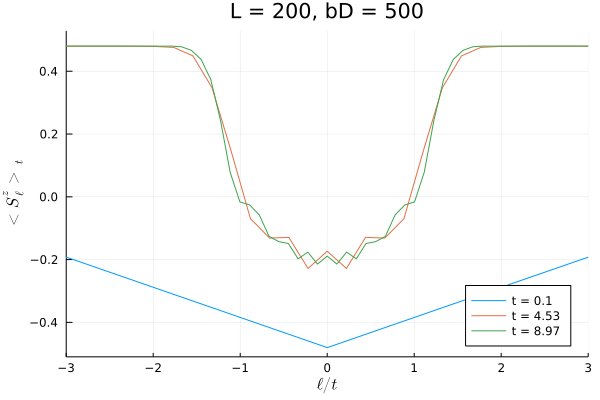

In [78]:
elle = length(Ls)
bonddim = length(bDs)
start = length(times[1])-6
finish = length(times[1])-4
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:length(times[elle])], (1,length(times[elle])-start+1))

plot(
    #[[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell"
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/t", xrange  = (-3,3)
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-9,9)
    , label = lege
    , ylabel = L"<S^z_\ell>_t"
    , legend = :bottomright
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim])"
)

In [79]:
magns_tot = [[
        [
            sum(magnetizations[k][j][i])
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

magns_tot_noflip = [[
        [
            sum(magnetizations_noflip[k][j][i])
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

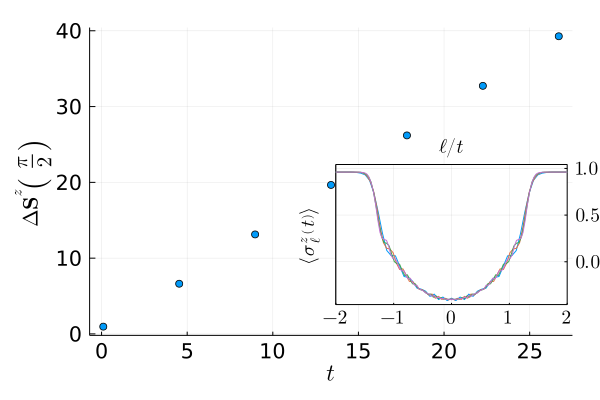

In [98]:
elle = length(Ls)
bonddim = length(bDs)
start = 1
finish = length(times[1])
lege = reshape(["L = $(Ls[elle]), bD = $(bDs[i])" for i=1:length(bDs)], (1, length(bDs)))

scatter(times[elle][start:finish], 
    [magns_tot_noflip[elle][bd][start:finish] .- magns_tot[elle][bd][start:finish] for bd=length(bDs):length(bDs)]
    , legend = :bottomright
    , xlabel = L"t"
    #, ylabel = L"\langle \Psi_0(t)|\mathbf{S}^z|\Psi_0(t)\rangle - \langle \Psi_{\frac{\pi}{2}}(t)|\mathbf{S}^z|\Psi_{\frac{\pi}{2}}(t)\rangle"
    , ylabel = L"\Delta\mathbf{S}^z\left(\frac{\pi}{2}\right)"
    #, label = lege
    , label = ""
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 14
    , legendfontsize = 12
    , margins = 5Plots.mm
)


elle = length(Ls)
bonddim = length(bDs)
start = length(times[1])-3
finish = length(times[1])
lege = reshape([L"t =" * "$(round(times[elle][i], digits=1))" for i=start:1:finish], (1,div(finish-start+1,1)))

# The call for instets is `bbox(x, y, width, height, origin...)`, 
# where numbers are treated as "percent of parent".
# For some reason I need to specify how many plots there are.
plot!(
    #[[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], 2 .* real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell"
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:1:finish], 2 .* real.(magnetizations[elle][bonddim])[start:1:finish], xrange  = (-2,2), xlabel = L"\ell/t"
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-7,7)
    #, label = lege
    , label = ""
    , ylabel = L"\langle\sigma^z_\ell\left(t\right)\rangle"
    , legend = :outerright
    , inset = (1, bbox(-0.07, 0.1, 0.56, 0.455, :bottom, :right))
    , subplot = 2
    , xticks = ([],[L"-2", L"-1", L"0", L"1", L"2"])
    , yticks = ([],[L"0.0", L"0.5", L"1.0"])
    , xmirror = :true
    , xguidefontsize = 13
    , yguidefontsize = 13
)
plot!(
    #[[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], 2 .* real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell"
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:1:finish], 2 .* real.(magnetizations[elle][bonddim])[start:1:finish], xrange  = (-2,2)#, xlabel = L"\ell/t"
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-7,7)
    #, label = lege
    , label = ""
    , ylabel = L"\langle\sigma^z_\ell(t)\rangle"
    , legend = :outerright
    , inset = (1, bbox(-0.07, 0.1, 0.56, 0.455, :bottom, :right))
    , subplot = 3
    , xticks = ([-2, -1, 0, 1, 2],[L"-2", L"-1", L"0", L"1", L"2"])
    , yticks = ([0, 0.5, 1],[L"0.0", L"0.5", L"1.0"])
    , xtickfontsize = 13
    , ytickfontsize = 13
    , box = :on
    , ymirror = :true
)



In [99]:
#savefig("img/paper_magn_trans_afterising.pdf")

## Full counting FLIP case

Given the full counting statistics, we can compute mean and variance of the distribution. We kinda know that the variance is directly linked to the macroscopic entanglement (if it grows a (system size)^2, or in our case, as time^2 (it is equivalente, given our lightcone structure). 

In [100]:
# for laptop:
#whereto = "/Users/saveriobocini/numerics_PhD/full_counted_statistics";

# for desktop
whereto = "/home/sbocini/Numerics_LabDesktop/full_counted_statistics";

In [101]:
elle = length(Ls)
bonddim1 = length(bDs)-1
bonddim2 = length(bDs)

result_loaded = DataFrame(load("$(whereto)/quantum_transistor/after_ising/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_hising$(h_ising)_tTOT$(tTOT)_dt$(dt)_bD$(bDs[bonddim1]).csv");)
;

imported_times = parse.(Float64, names(result_loaded));
imported_fcs1 = [result_loaded[!, i] for i = 1:length(imported_times)];

result_loaded = DataFrame(load("$(whereto)/quantum_transistor/after_ising/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_hising$(h_ising)_tTOT$(tTOT)_dt$(dt)_bD$(bDs[bonddim2]).csv");)
;
imported_fcs2 = [result_loaded[!, i] for i = 1:length(imported_times)];

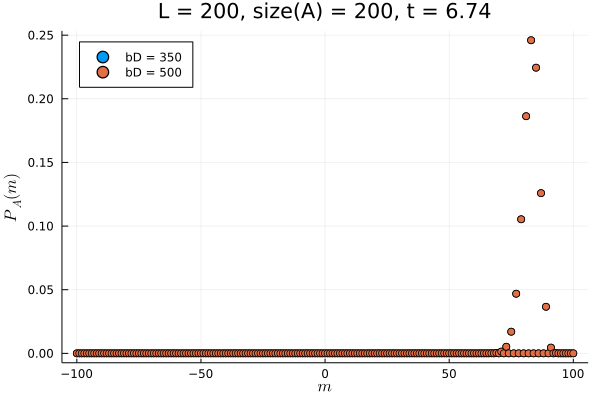

In [68]:
tt = length(times[1])-4

scatter([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs1[tt]
    , label = "bD = $(bDs[end-1])"
    , legend = :topleft
    , title = "L = $(Ls[elle]), size(A) = $(Ls[end]), t = $(round(imported_times[tt], digits=2))"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

scatter!([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs2[tt]
    , label = "bD = $(bDs[end])"
)

In [69]:
[sum(imported_fcs1[tt]), sum(imported_fcs2[tt])]

2-element Vector{Float64}:
 0.9999996285996298
 0.9999996285996298

In [102]:
mean_magnetization1 = meanFCS.(imported_fcs1) 
magnetization_variance1 = varianceFCS.(imported_fcs1) 

mean_magnetization2 = meanFCS.(imported_fcs2) 
magnetization_variance2 = varianceFCS.(imported_fcs2) ;

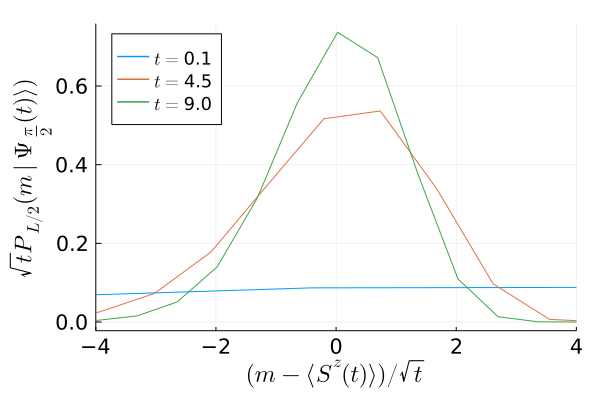

In [103]:
start = length(times[1])-6
finish = length(times[1])-4
lege = reshape([L"t=" * "$(round(imported_times[i], digits=1))" for i=start:1:finish], (1, div(finish - start + 1,1)))

plot([[(i - mean_magnetization2[rr]) / sqrt(times[elle][rr]) 
                for i=-div(Ls[elle], 2)+1:2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2[rr][2:2:end] * sqrt(times[elle][rr]) 
        for rr in start:1:finish] 
    , label = lege
    , legend = :topleft
    #, title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end]), only odd m"
    , xlabel = L"(m-\langle S^z(t)\rangle)/\sqrt{t}"
    , ylabel = L"\sqrt{t}P_{L/2}(m~|\Psi_{\frac{\pi}{2}}(t)\rangle)"
    , xrange = (-4, 4)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margins = 4Plots.mm
)

In [24]:
#savefig("img/paper_fcs_dualXX_afterIs.pdf")

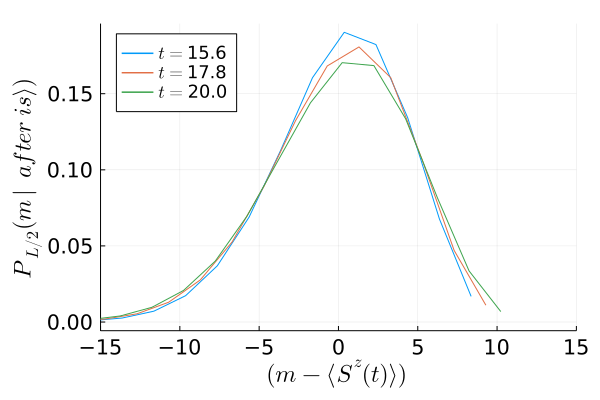

In [25]:
start = length(times[1]) - 2
finish = length(times[1])
lege = reshape([L"t=" * "$(round(imported_times[i], digits=1))" for i=start:1:finish], (1, div(finish - start + 1,1)))

plot([[(i - mean_magnetization2[rr]) 
                for i=-div(Ls[elle], 2)+1:2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2[rr][2:2:end] 
        for rr in start:1:finish] 
    , label = lege
    , legend = :topleft
    #, title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end]), only odd m"
    , xlabel = L"(m-\langle S^z(t)\rangle)"
    , ylabel = L"P_{L/2}(m~|~after~is\rangle)"
    , xrange = (-15, 15)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margins = 4Plots.mm
)

## Full counting ROTATED case

In [104]:
# for laptop:
#whereto = "/Users/saveriobocini/numerics_PhD/full_counted_statistics_CAT";

# for desktop
whereto = "/home/sbocini/Numerics_LabDesktop/full_counted_statistics_CAT";

In [105]:
elle = length(Ls)
bonddim1 = length(bDs)-1
bonddim2 = length(bDs)

result_loaded = DataFrame(load("$(whereto)/quantum_transistor/after_ising/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_hising$(h_ising)_tTOT$(tTOT)_dt$(dt)_bD$(bDs[bonddim1]).csv");)
;

imported_times = parse.(Float64, names(result_loaded));
imported_fcs1cat = [result_loaded[!, i] for i = 1:length(imported_times)];

result_loaded = DataFrame(load("$(whereto)/quantum_transistor/after_ising/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_hising$(h_ising)_tTOT$(tTOT)_dt$(dt)_bD$(bDs[bonddim2]).csv");)
;
imported_fcs2cat = [result_loaded[!, i] for i = 1:length(imported_times)];

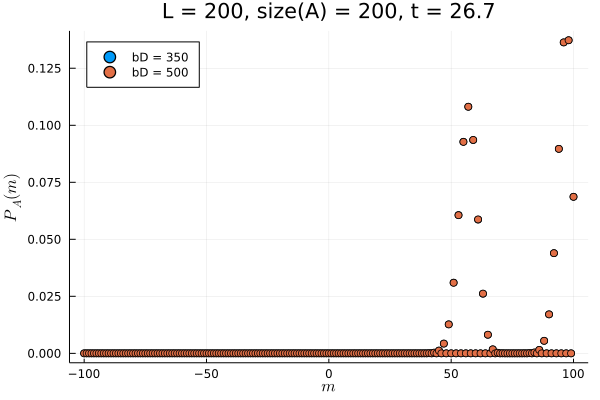

In [106]:
tt = length(imported_times)

scatter([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs1cat[tt]
    , label = "bD = $(bDs[end-1])"
    , legend = :topleft
    , title = "L = $(Ls[elle]), size(A) = $(Ls[end]), t = $(round(imported_times[tt], digits=2))"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

scatter!([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs2cat[tt]
    , label = "bD = $(bDs[end])"
)

In [107]:
[sum(imported_fcs1cat[tt]), sum(imported_fcs2cat[tt])]

2-element Vector{Float64}:
 0.9999952182108197
 0.9999972904058547

In [108]:
mean_magnetization1cat = meanFCS.(imported_fcs1cat) 
magnetization_variance1cat = varianceFCS.(imported_fcs1cat) 

mean_magnetization2cat = meanFCS.(imported_fcs2cat) 
magnetization_variance2cat = varianceFCS.(imported_fcs2cat) ;

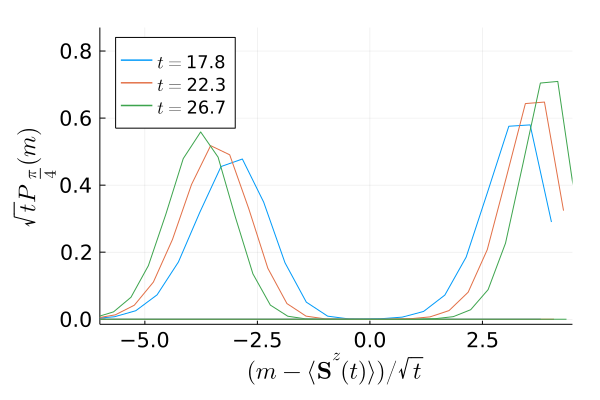

In [130]:
start = length(times[1]) - 2
finish = length(times[1])
lege = reshape([L"t=" * "$(round(imported_times[i], digits=1))" for i=start:1:finish], (1, div(finish - start + 1,1)))
color_legend = reshape([i for i=1:finish-start+1], (1, finish-start+1)) 

plot([[(i - mean_magnetization2cat[rr]) / sqrt(times[elle][rr]) 
                for i=-div(Ls[elle], 2)+1:2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2cat[rr][2:2:end] * sqrt(times[elle][rr]) 
        for rr in start:1:finish] 
    , label = lege
    , legend = :topleft
    #, title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end]), only odd m"
    , xlabel = L"(m-\langle \mathbf{S}^z(t)\rangle)/\sqrt{t}"
    , ylabel = L"\sqrt{t}P_{\frac{\pi}{4}}( m)"
    , xrange = (-6,6)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margin = 4Plots.mm
)

plot!([[(i - mean_magnetization2cat[rr]) / sqrt(times[elle][rr]) 
                for i=-div(Ls[elle], 2):2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2cat[rr][1:2:end] * sqrt(times[elle][rr]) 
        for rr in start:1:finish] 
    , label = ""
    , legend = :topleft
    #, title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end]), only odd m"
    , xrange = (-6,4.5)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margin = 5Plots.mm
    , color = color_legend
    , yrange = (-0.015, 0.87)
)


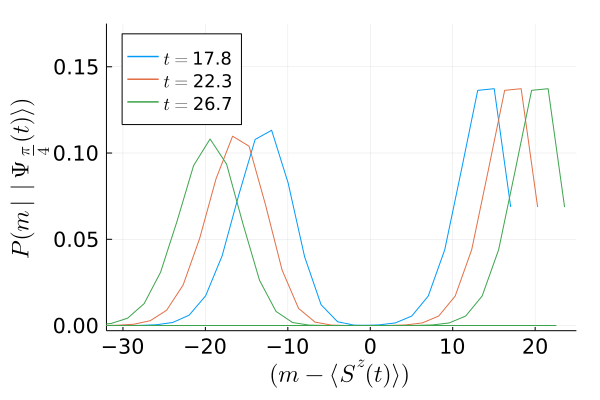

In [128]:
start = length(times[1]) - 2
finish = length(times[1])
lege = reshape([L"t=" * "$(round(imported_times[i], digits=1))" for i=start:1:finish], (1, div(finish - start + 1,1)))
color_legend = reshape([i for i=1:finish-start+1], (1, finish-start+1)) 

plot([[(i - mean_magnetization2cat[rr]) 
                for i=-div(Ls[elle], 2)+1:2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2cat[rr][2:2:end]
        for rr in start:1:finish] 
    , label = lege
    , legend = :topright
    #, title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end]), only odd m"
    , xlabel = L"(m-\langle S^z(t)\rangle)"
    , ylabel = L"P( m~|~|\Psi_{\frac{\pi}{4}}(t)\rangle)"
    , xrange = (-32,25)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margin = 4Plots.mm
)

plot!([[(i - mean_magnetization2cat[rr]) 
                for i=-div(Ls[elle], 2):2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2cat[rr][1:2:end]
        for rr in start:1:finish] 
    , label = ""
    , legend = :topleft
    #, title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end]), only odd m"
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margin = 4Plots.mm
    , color = color_legend
    , yrange = (-0.003, 0.175)
)

In [131]:
#savefig("./img/paper_fcsCat_dualXX_afterIs.pdf")

## Counting Sx

In [ ]:
function eiM_forX(θ, psi, ell) 
    siti = siteinds(psi)
    lunghezza = length(psi)
    outpu = ITensor[]
    for j in siti[- div(ell, 2) + 1 + div(lunghezza, 2) : div(ell, 2) + div(lunghezza, 2)]
        ope = op("Sx", j)
        push!(outpu, exp(2im * pi * θ * ope / (ell + 1)))
    end
    outpu
end

G_forX(state, ell) = [inner(state, apply(eiM_forX(k, state, ell), state)) for k=-div(ell, 2):div(ell, 2)]

In [ ]:
function full_counting_ofX(state, ell)
    Gk = G_forX(state, ell)
    outpu = ComplexF64[]
    rangeh = div(ell, 2)
    for m = -rangeh:rangeh
        expophase = [exp(- 2im * pi * k * m / (ell + 1)) for k=-rangeh:rangeh]
        push!(outpu, sum(expophase .* Gk) / (ell + 1))
    end
    outpu
end
        

In [ ]:
subsys = Ls[end]
bonddim = 2

full_countedXs = [
    [
        real(full_counting_ofX(states[end][bd][i], subsys)) 
        for i=1:length(times[end])
    ] for bd = bonddim:bonddim
];

In [ ]:
start = 3
finish = 5
lege = reshape(["t = $(round(times[end][i], digits=2))" for i=start:finish], (1, finish - start + 1))

plot([i for i=-div(subsys, 2):div(subsys, 2)], 
    full_countedXs[end][start:finish]
    , label = lege
    , legend = :topleft
    , title = "L = $(Ls[end]), bD = $(bDs[bonddim]), size(A) = $subsys"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
    , xrange = (-25,25)
)

In [ ]:
start = 3
finish = 5
lege = reshape(["t = $(round(times[end][i], digits=2))" for i=start:finish], (1, finish - start + 1))

plot([[i for i=-div(subsys, 2):div(subsys, 2)] ./ sqrt(times[end][tt]) for tt = start:finish], 
    [full_countedXs[end][tt] .* sqrt(times[end][tt]) for tt = start:finish]
    , label = lege
    , legend = :topleft
    , title = "L = $(Ls[end]), bD = $(bDs[bonddim]), size(A) = $subsys"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
    , xrange = (-10,10)
)

## Other local observables

In [ ]:
elle = length(Ls)
bonddim = length(bDs)

XXcorrs = [
    [
        real(XXcorr(states[elle][bonddim][t], i, i+1))
        for i = 1:Ls[elle]-1
    ] for t = 1:length(times[elle])
];

In [ ]:
start = 1
finish = 5
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:length(times[elle])], (1,length(times[elle])-start+1))

plot(
    [[l+0.5 for l=1-Ls[elle]/2:Ls[elle]/2-1] for t in times[elle]][start:end], XXcorrs
    , label = lege
    , xlabel = L"i"
    , ylabel = L"<S^x_i S^x_{i+1}>_t"
)

## Energy

This is just a check that time-evolution works fine, of course energy should be constant.

In [ ]:
tot_energies = [inner(states[end][end][i], apply(H_tobeapplied(states[end][end][i]), states[end][end][i])) for i = 1:length(states[end][end])]
;

In [ ]:
scatter(times[end], real.(tot_energies) .- real.(tot_energies[1])
    , xlabel = L"t"
    , ylabel = L"E_{tot}(t) - E_{tot}(0)"
    , label = ""
)

## No flip case

In [ ]:
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0
dt = 0.01;
tTOT = 20

Δt = 0.2
h_ising = 0.6

Ls = [80]
bDs = [100, 200];

In [ ]:
# for laptop:
#base_path = "/Users/saveriobocini/numerics_PhD/quantum_transistor/after_ising_noflip";

# for desktop
base_path = "/home/sbocini/Numerics_LabDesktop/quantum_transistor/after_ising_noflip";


times = [
    load("$(base_path)/L$(L)_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_hising$(h_ising)_tTOT$(tTOT)_BondDim$(bDs[1])_dt$(dt).jld2"
    , "times") for L in Ls
];

states = [
    [
        [
            load("$(base_path)/L$(Ls[k])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_hising$(h_ising)_tTOT$(tTOT)_BondDim$(bDs[j])_dt$(dt).jld2"
                , "t$(round(times[k][i], digits=3))")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [ ]:
magnetizations = [
    [
        [
            expect(states[k][j][i], "Sz")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [ ]:
elle = length(Ls)
bonddim = length(bDs)
start = 4
finish = 8
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:length(times[elle])], (1,length(times[elle])-start+1))

plot(
    [[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell"
    #[[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/t", xrange  = (-3,3)
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-9,9)
    , label = lege
    , ylabel = L"<S^z_\ell>_t"
    , legend = :bottomright
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim])"
    , xrange = (-9,9)
    , yrange = (0.42,0.43)
)

In [ ]:
magnetizationsX = [
    [
        [
            expect(states[k][j][i], "Sx")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [ ]:
elle = length(Ls)
bonddim = length(bDs)
start = 4
finish = 8
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:length(times[elle])], (1,length(times[elle])-start+1))

plot(
    [[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizationsX[elle][bonddim])[start:finish], xlabel = L"\ell"
    #[[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/t", xrange  = (-3,3)
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-9,9)
    , label = lege
    , ylabel = L"<S^x_\ell>_t"
    , legend = :bottomright
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim])"
)

In [ ]:
function eiM_forX(θ, psi, ell) 
    siti = siteinds(psi)
    lunghezza = length(psi)
    outpu = ITensor[]
    for j in siti[- div(ell, 2) + 1 + div(lunghezza, 2) : div(ell, 2) + div(lunghezza, 2)]
        ope = op("Sx", j)
        push!(outpu, exp(2im * pi * θ * ope / (ell + 1)))
    end
    outpu
end

G_forX(state, ell) = [inner(state, apply(eiM_forX(k, state, ell), state)) for k=-div(ell, 2):div(ell, 2)]

In [ ]:
function full_counting_ofX(state, ell)
    Gk = G_forX(state, ell)
    outpu = ComplexF64[]
    rangeh = div(ell, 2)
    for m = -rangeh:rangeh
        expophase = [exp(- 2im * pi * k * m / (ell + 1)) for k=-rangeh:rangeh]
        push!(outpu, sum(expophase .* Gk) / (ell + 1))
    end
    outpu
end
        

In [ ]:
subsys = Ls[end]
bonddim = 2

full_countedXs = [
    [
        real(full_counting_ofX(states[end][bd][i], subsys)) 
        for i=1:length(times[end])
    ] for bd = bonddim:bonddim
];

In [ ]:
start = 3
finish = 8
lege = reshape(["t = $(round(times[end][i], digits=2))" for i=start:finish], (1, finish - start + 1))

plot([i for i=-div(subsys, 2):div(subsys, 2)], 
    full_countedXs[end][start:finish]
    , label = lege
    , legend = :topleft
    , title = "L = $(Ls[end]), bD = $(bDs[bonddim]), size(A) = $subsys"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
    , xrange = (-25,25)
)

In [ ]:
start = 3
finish = 8
lege = reshape(["t = $(round(times[end][i], digits=2))" for i=start:finish], (1, finish - start + 1))

plot([[i for i=-div(subsys, 2):div(subsys, 2)] ./ sqrt(times[end][tt]) for tt = start:finish], 
    [full_countedXs[end][tt] .* sqrt(times[end][tt]) for tt = start:finish]
    , label = lege
    , legend = :topleft
    , title = "L = $(Ls[end]), bD = $(bDs[bonddim]), size(A) = $subsys"
    , xlabel = L"m/\sqrt{t}"
    , ylabel = L"\sqrt{t}P_A(m)"
    , xrange = (-10,10)
)

In [ ]:
elle = length(Ls)
bonddim = length(bDs)

XXcorrs = [
    [
        real(XXcorr(states[elle][bonddim][t], i, i+1))
        for i = 1:Ls[elle]-1
    ] for t = 1:length(times[elle])
];

In [ ]:
start = 1
finish = 5
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:length(times[elle])], (1,length(times[elle])-start+1))

plot(
    [[l+0.5 for l=1-Ls[elle]/2:Ls[elle]/2-1] for t in times[elle]][start:end], XXcorrs
    , label = lege
    , xlabel = L"i"
    , ylabel = L"<S^x_i S^x_{i+1}>_t"
)

# Evolving first with non-integrable Ising

## Loading states

In [ ]:
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0

Δt = 0.2
hz_Is = 0.4
hx_Is = 0.9
tTOT = 20
dt = 0.01;

Ls = [100]
bDs = [100, 200];

In [ ]:
# quite ugly: it seems that the even sites follow a different evolution wrt the odd ones (which is possible)
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0

Δt = 0.1
hz_Is = 0.4
hx_Is = 0.6
tTOT = 10
dt = 0.01;

Ls = [80]
bDs = [100, 200];

In [132]:
# fcs in flip-case computed in both cases
# it's in the PAPER at the moment
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0

Δt = 0.1
hz_Is = 0.7
hx_Is = 0.5
tTOT = 30
dt = 0.01;

Ls = [150]
bDs = [250, 400];

In [ ]:
# I still have to compute the fcs for cat case
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0

Δt = 0.1
hz_Is = 1.3
hx_Is = 0.5
tTOT = 24
dt = 0.01;

Ls = [120]
bDs = [250, 400];

In [ ]:
# fcs in flip-case computed, working on the rotated case
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0

Δt = 0.03
hz_Is = 0.7
hx_Is = 0.5
tTOT = 24
dt = 0.01;

Ls = [120]
bDs = [250, 400];

In [133]:
# for laptop:
#base_path = "/Users/saveriobocini/numerics_PhD/quantum_transistor/after_isingNonInt";

# for desktop
base_path = "/home/sbocini/Numerics_LabDesktop/quantum_transistor/after_isingNonInt";


times = [
    load("$(base_path)/L$(L)_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_hZising$(hz_Is)_hXising$(hx_Is)_tTOT$(tTOT)_BondDim$(bDs[1])_dt$(dt).jld2"
    , "times") for L in Ls
];

states = [
    [
        [
            load("$(base_path)/L$(Ls[k])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_hZising$(hz_Is)_hXising$(hx_Is)_tTOT$(tTOT)_BondDim$(bDs[j])_dt$(dt).jld2"
                , "t$(round(times[k][i], digits=3))")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [134]:
states_noflip = [
    [
        [
            load("$(base_path)_noflip/L$(Ls[k])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_hZising$(hz_Is)_hXising$(hx_Is)_tTOT$(tTOT)_BondDim$(bDs[j])_dt$(dt).jld2"
                , "t$(round(times[k][i], digits=3))")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

## Magnetization

In [135]:
magnetizations = [
    [
        [
            expect(states[k][j][i], "Sz")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [136]:
magnetizations_noflip = [
    [
        [
            expect(states_noflip[k][j][i], "Sz")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

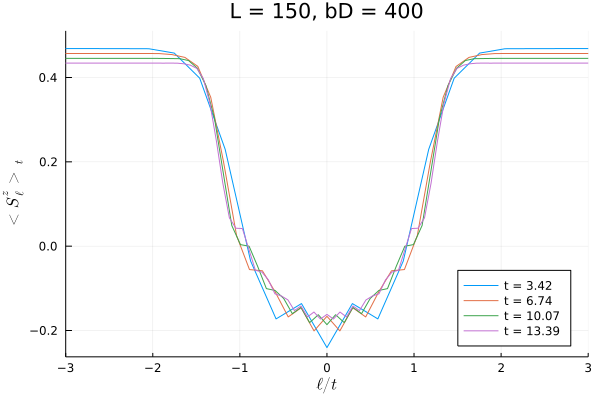

In [137]:
elle = length(Ls)
bonddim = length(bDs)
start = length(times[1])-3
finish = length(times[1])
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:length(times[elle])], (1,length(times[elle])-start+1))

plot(
    #[[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell"
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/t", xrange  = (-3,3)
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-9,9)
    , label = lege
    , ylabel = L"<S^z_\ell>_t"
    , legend = :bottomright
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim])"
)

In [138]:
magns_tot = [[
        [
            sum(magnetizations[k][j][i])
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

magns_tot_noflip = [[
        [
            sum(magnetizations_noflip[k][j][i])
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

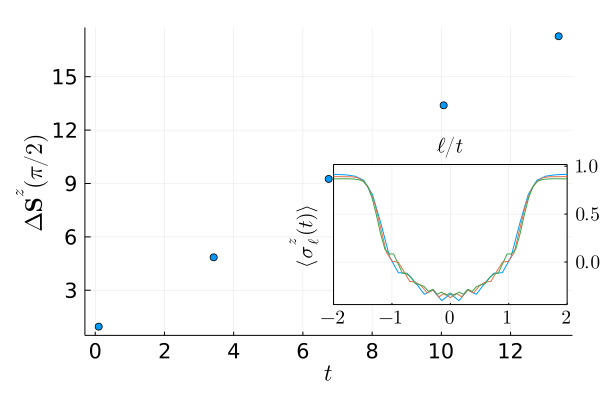

In [188]:
elle = length(Ls)
bonddim = length(bDs)
start = 1
finish = length(times[1])
lege = reshape(["L = $(Ls[elle]), bD = $(bDs[i])" for i=1:length(bDs)], (1, length(bDs)))

scatter(times[elle][start:finish], 
    [magns_tot_noflip[elle][bd][start:finish] .- magns_tot[elle][bd][start:finish] for bd=length(bDs):length(bDs)]
    , legend = :bottomright
    , xlabel = L"t"
    #, ylabel = L"\langle \Psi_0(t)|\mathbf{S}^z|\Psi_0(t)\rangle - \langle \Psi_{\frac{\pi}{2}}(t)|\mathbf{S}^z|\Psi_{\frac{\pi}{2}}(t)\rangle"
    , ylabel = L"\Delta\mathbf{S}^z(\pi/2)"
    #, label = lege
    , label = ""
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margins = 5Plots.mm
)


elle = length(Ls)
bonddim = length(bDs)
start = length(times[1])-2
finish = length(times[1])
lege = reshape([L"t =" * "$(round(times[elle][i], digits=1))" for i=start:1:finish], (1,div(finish-start+1,1)))

# The call for instets is `bbox(x, y, width, height, origin...)`, 
# where numbers are treated as "percent of parent".
# For some reason I need to specify how many plots there are.
plot!(
    #[[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], 2 .* real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell"
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:1:finish], 2 .* real.(magnetizations[elle][bonddim])[start:1:finish], xrange  = (-2,2), xlabel = L"\ell/t"
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-7,7)
    #, label = lege
    , label = ""
    , ylabel = L"\langle\mathbf{\sigma}^z_\ell(t)\rangle"
    , legend = :outerright
    , inset = (1, bbox(-0.07, 0.1, 0.56, 0.455, :bottom, :right))
    , subplot = 2
    , xticks = ([],[L"-2", L"-1", L"0", L"1", L"2"])
    , yticks = ([],[L"0.0", L"0.5", L"1.0"])
    , xmirror = :true
    , xguidefontsize = 14
    , yguidefontsize = 14
)
plot!(
    #[[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], 2 .* real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell"
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:1:finish], 2 .* real.(magnetizations[elle][bonddim])[start:1:finish], xrange  = (-2,2)#, xlabel = L"\ell/t"
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-7,7)
    #, label = lege
    , label = ""
    , ylabel = L"\langle\mathbf{sigma}^z_\ell(t)\rangle"
    , legend = :outerright
    , inset = (1, bbox(-0.07, 0.1, 0.56, 0.455, :bottom, :right))
    , subplot = 3
    , xticks = ([-2, -1, 0, 1, 2],[L"-2", L"-1", L"0", L"1", L"2"])
    , yticks = ([0, 0.5, 1],[L"0.0", L"0.5", L"1.0"])
    , xtickfontsize = 13
    , ytickfontsize = 13
    , box = :on
    , ymirror = :true
)



In [189]:
#savefig("img/paper_magn_trans_afterisingNonInt.pdf")

## Full counting FLIP case

Given the full counting statistics, we can compute mean and variance of the distribution. We kinda know that the variance is directly linked to the macroscopic entanglement (if it grows a (system size)^2, or in our case, as time^2 (it is equivalente, given our lightcone structure). 

In [150]:
# for laptop:
#whereto = "/Users/saveriobocini/numerics_PhD/full_counted_statistics";

# for desktop
whereto = "/home/sbocini/Numerics_LabDesktop/full_counted_statistics";

In [151]:
elle = length(Ls)
bonddim1 = length(bDs)-1
bonddim2 = length(bDs)

result_loaded = DataFrame(load("$(whereto)/quantum_transistor/after_isingNonInt/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_hZising$(hz_Is)_hXising$(hx_Is)_tTOT$(tTOT)_dt$(dt)_bD$(bDs[bonddim1]).csv");)
;

imported_times = parse.(Float64, names(result_loaded));
imported_fcs1 = [result_loaded[!, i] for i = 1:length(imported_times)];

result_loaded = DataFrame(load("$(whereto)/quantum_transistor/after_isingNonInt/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_hZising$(hz_Is)_hXising$(hx_Is)_tTOT$(tTOT)_dt$(dt)_bD$(bDs[bonddim2]).csv");)
;
imported_fcs2 = [result_loaded[!, i] for i = 1:length(imported_times)];

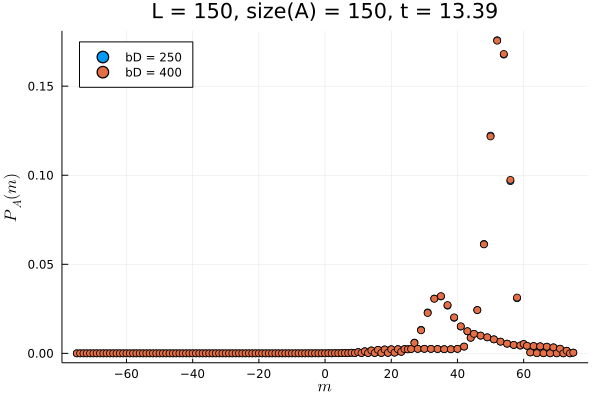

In [152]:
tt = length(times[1])
scatter([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs1[tt]
    , label = "bD = $(bDs[end-1])"
    , legend = :topleft
    , title = "L = $(Ls[elle]), size(A) = $(Ls[end]), t = $(round(imported_times[tt], digits=2))"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

scatter!([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs2[tt]
    , label = "bD = $(bDs[end])"
)

In [153]:
[sum(imported_fcs1[tt]), sum(imported_fcs2[tt])]

2-element Vector{Float64}:
 0.9998396543655114
 0.9999485235395305

In [154]:
function meanFCSodd(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    norma = sum(fullcountedstatistics[2:2:end])
    sum([j for j=-div(ell,2)+1:2:div(ell,2)] .* fullcountedstatistics[2:2:end]) / norma
end

function meanFCSeven(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    norma = sum(fullcountedstatistics[1:2:end])
    sum([j for j=-div(ell,2):2:div(ell,2)] .* fullcountedstatistics[1:2:end]) / norma
end

meanFCSeven (generic function with 1 method)

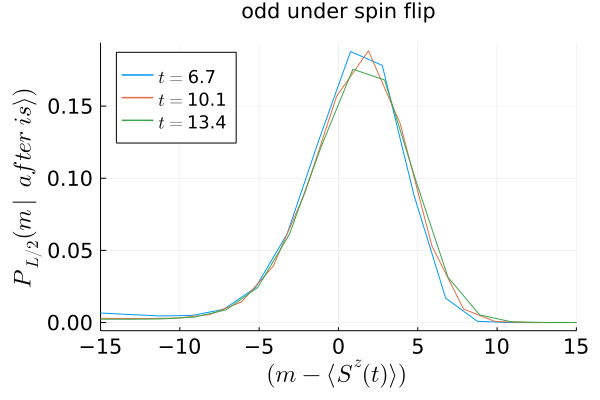

In [155]:
start = length(times[1]) - 2
finish = length(times[1])
lege = reshape([L"t=" * "$(round(imported_times[i], digits=1))" for i=start:1:finish], (1, div(finish - start + 1,1)))

plot([[(i - meanFCSodd(imported_fcs2[rr]))         
                for i=-div(Ls[elle], 2)+1:2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2[rr][2:2:end] 
        for rr in start:1:finish] 
    , label = lege
    , legend = :topleft
    , title = "odd under spin flip"
    , xlabel = L"(m-\langle S^z(t)\rangle)"
    , ylabel = L"P_{L/2}(m~|~after~is\rangle)"
    , xrange = (-15, 15)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margins = 4Plots.mm
)

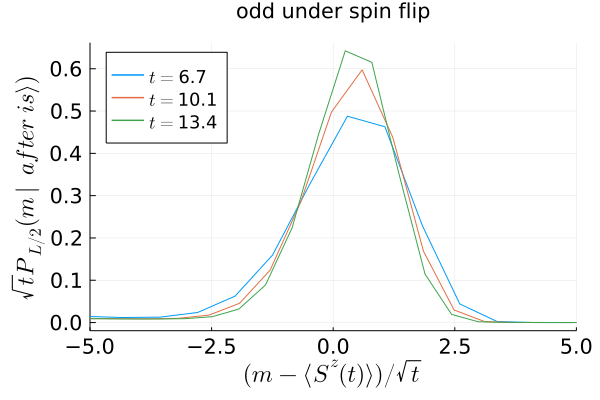

In [156]:
start = length(times[1]) - 2
finish = length(times[1])
lege = reshape([L"t=" * "$(round(imported_times[i], digits=1))" for i=start:1:finish], (1, div(finish - start + 1,1)))

plot([[(i - meanFCSodd(imported_fcs2[rr])) / sqrt(times[elle][rr])
                for i=-div(Ls[elle], 2)+1:2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2[rr][2:2:end] .* sqrt(times[elle][rr])
        for rr in start:1:finish] 
    , label = lege
    , legend = :topleft
    , title = "odd under spin flip"
    , xlabel = L"(m-\langle S^z(t)\rangle)/\sqrt{t}"
    , ylabel = L"\sqrt{t}P_{L/2}(m~|~after~is\rangle)"
    , xrange = (-5, 5)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margins = 4Plots.mm
)

In [ ]:
start = length(times[1]) - 2
finish = length(times[1])
lege = reshape([L"t=" * "$(round(imported_times[i], digits=1))" for i=start:1:finish], (1, div(finish - start + 1,1)))

plot([[(i - meanFCSeven(imported_fcs2[rr])) 
                for i=-div(Ls[elle], 2):2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2[rr][1:2:end] 
        for rr in start:1:finish] 
    , label = lege
    , legend = :topleft
    , title = "even under spin flip"
    , xlabel = L"(m-\langle S^z(t)\rangle)"
    , ylabel = L"P_{L/2}(m~|~after~is\rangle)"
    , xrange = (-30, 40)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margins = 4Plots.mm
)

In [ ]:
start = length(times[1]) - 2
finish = length(times[1])
lege = reshape([L"t=" * "$(round(imported_times[i], digits=1))" for i=start:1:finish], (1, div(finish - start + 1,1)))

plot([[(i - meanFCSeven(imported_fcs2[rr])) / sqrt(times[elle][rr])
                for i=-div(Ls[elle], 2):2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2[rr][1:2:end] .* sqrt(times[elle][rr])
        for rr in start:1:finish] 
    , label = lege
    , legend = :topleft
    , title = "even under spin flip"
    , xlabel = L"(m-\langle S^z(t)\rangle)/\sqrt{t}"
    , ylabel = L"\sqrt{t}P(m~|~|\Psi_{\frac{\pi}{4}}(t)\rangle)"
    , xrange = (-10, 10)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margins = 4Plots.mm
)

## Full counting ROTATED case

In [157]:
function meanFCS(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    sum([j for j=-div(ell,2):div(ell,2)] .* fullcountedstatistics)
end

function varianceFCS(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    mmm = meanFCS(fullcountedstatistics)
    sum([(j - mmm)^2 for j=-div(ell,2):div(ell,2)] .* fullcountedstatistics)
end


varianceFCS (generic function with 1 method)

In [158]:
# for laptop:
#whereto = "/Users/saveriobocini/numerics_PhD/full_counted_statistics_CAT";

# for desktop
whereto = "/home/sbocini/Numerics_LabDesktop/full_counted_statistics_CAT";

In [159]:
elle = length(Ls)
bonddim1 = length(bDs)-1
bonddim2 = length(bDs)

result_loaded = DataFrame(load("$(whereto)/quantum_transistor/after_isingNonInt/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_hZising$(hz_Is)_hXising$(hx_Is)_tTOT$(tTOT)_dt$(dt)_bD$(bDs[bonddim1]).csv");)
;

imported_times = parse.(Float64, names(result_loaded));
imported_fcs1cat = [result_loaded[!, i] for i = 1:length(imported_times)];

result_loaded = DataFrame(load("$(whereto)/quantum_transistor/after_isingNonInt/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_hZising$(hz_Is)_hXising$(hx_Is)_tTOT$(tTOT)_dt$(dt)_bD$(bDs[bonddim2]).csv");)
;
imported_fcs2cat = [result_loaded[!, i] for i = 1:length(imported_times)];

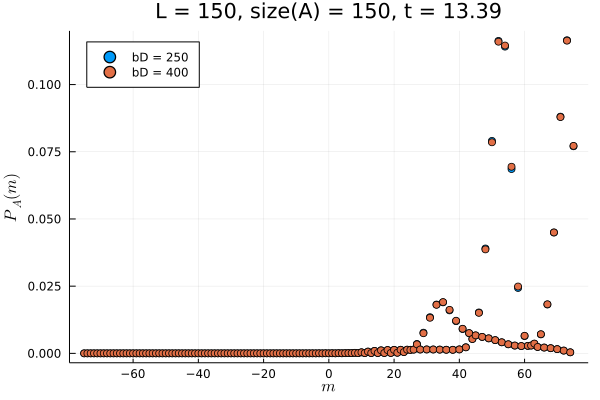

In [160]:
tt = length(imported_times)

scatter([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs1cat[tt]
    , label = "bD = $(bDs[end-1])"
    , legend = :topleft
    , title = "L = $(Ls[elle]), size(A) = $(Ls[end]), t = $(round(imported_times[tt], digits=2))"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

scatter!([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs2cat[tt]
    , label = "bD = $(bDs[end])"
)

In [161]:
[sum(imported_fcs1cat[tt]), sum(imported_fcs2cat[tt])]

2-element Vector{Float64}:
 1.0065670526518449
 1.0068023415953165

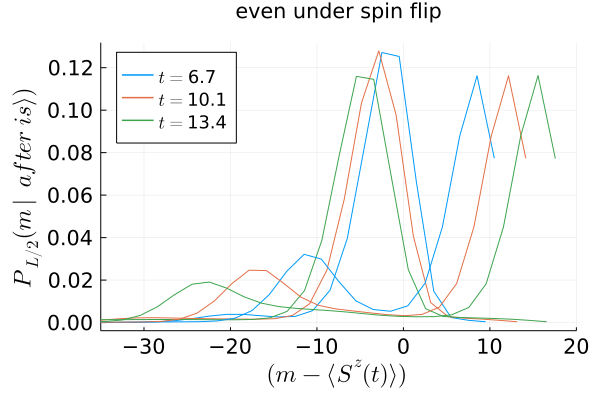

In [168]:
start = length(times[1]) - 2
finish = length(times[1])
lege = reshape([L"t=" * "$(round(imported_times[i], digits=1))" for i=start:1:finish], (1, div(finish - start + 1,1)))

plot([[(i - meanFCS(imported_fcs2cat[rr]))         
                for i=-div(Ls[elle], 2)+1:2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2cat[rr][2:2:end] 
        for rr in start:1:finish] 
    , label = lege
    , legend = :topleft
    , title = "odd under spin flip"
    , xlabel = L"(m-\langle S^z(t)\rangle)"
    , ylabel = L"P(m~|~|\Psi_{\frac{\pi}{4}}(t)\rangle)"
    , xrange = (-35, 20)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margins = 4Plots.mm
)

plot!([[(i - meanFCS(imported_fcs2cat[rr])) 
                for i=-div(Ls[elle], 2):2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2cat[rr][1:2:end] 
        for rr in start:1:finish] 
    , label = ""
    , legend = :topleft
    , title = "even under spin flip"
    , xlabel = L"(m-\langle S^z(t)\rangle)"
    , ylabel = L"P_{L/2}(m~|~after~is\rangle)"
    , xrange = (-35, 20)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margins = 4Plots.mm
    , color = [1 2 3]
)

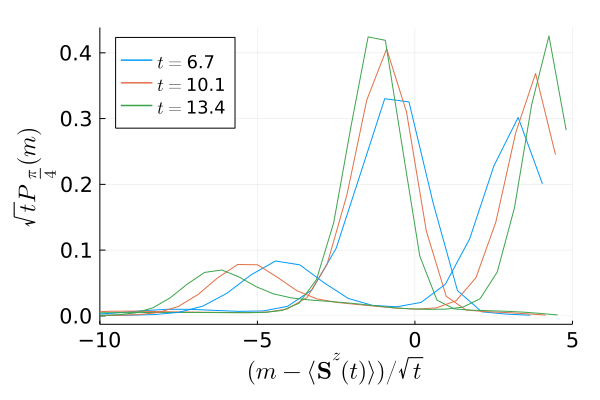

In [186]:
start = length(times[1]) - 2
finish = length(times[1])
lege = reshape([L"t=" * "$(round(imported_times[i], digits=1))" for i=start:1:finish], (1, div(finish - start + 1,1)))

plot([[(i - meanFCS(imported_fcs2cat[rr])) ./ sqrt(times[elle][rr])         
                for i=-div(Ls[elle], 2)+1:2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2cat[rr][2:2:end] .* sqrt(times[elle][rr]) 
        for rr in start:1:finish] 
    , label = lege
    , legend = :topleft
    #, title = "odd under spin flip"
    , xlabel = L"(m-\langle \mathbf{S}^z(t)\rangle)/\sqrt{t}"
    , ylabel = L"\sqrt{t} P_\frac{\pi}{4}(m)"
    , xrange = (-10, 5)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margins = 5Plots.mm
)

plot!([[(i - meanFCS(imported_fcs2cat[rr])) 
                for i=-div(Ls[elle], 2):2:div(Ls[elle], 2)] ./ sqrt(times[elle][rr]) 
        for rr in start:1:finish], 
    [imported_fcs2cat[rr][1:2:end] .* sqrt(times[elle][rr]) 
        for rr in start:1:finish] 
    , label = ""
    , legend = :topleft
    #, title = "even under spin flip"
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , color = [1 2 3]
)

In [187]:
#savefig("./img/paper_fcsCat_dualXX_afterIsNonInt.pdf")

# Evolving first with XY

## Loading states

In [ ]:
# the rescaled one probably looks a bit better
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0

Δt = 0.2
γ = 0.5
h_XY = 0.6
tTOT = 20
dt = 0.01;

Ls = [120]
bDs = [100, 200];

In [ ]:
# fcs looks better in the rescaled case.
# fcs computed both in flip and cat case.
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0

Δt = 0.1
γ = 0.5
h_XY = 0.6
tTOT = 40
dt = 0.01;

Ls = [160]
bDs = [250, 400];

In [ ]:
# fcs looks better in the rescaled case. 
# fcs computed both in flip and cat case.
Jx = 0.7
Jy = 0.0
Jz = 0.0
h = 0.0

Δt = 0.2
γ = 0.5
h_XY = 0.6
tTOT = 40
dt = 0.01;

Ls = [160]
bDs = [250, 400];

In [ ]:
# for laptop:
base_path = "/Users/saveriobocini/numerics_PhD/quantum_transistor/after_XY";

# for desktop
#base_path = "/home/sbocini/Numerics_LabDesktop/quantum_transistor/after_XY";


times = [
    load("$(base_path)/L$(L)_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_gammaXY$(γ)_hXY$(h_XY)_tTOT$(tTOT)_BondDim$(bDs[1])_dt$(dt).jld2"
    , "times") for L in Ls
];

states = [
    [
        [
            load("$(base_path)/L$(Ls[k])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_gammaXY$(γ)_hXY$(h_XY)_tTOT$(tTOT)_BondDim$(bDs[j])_dt$(dt).jld2"
                , "t$(round(times[k][i], digits=3))")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [ ]:
states_noflip = [
    [
        [
            load("$(base_path)_noflip/L$(Ls[k])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_gammaXY$(γ)_hXY$(h_XY)_tTOT$(tTOT)_BondDim$(bDs[j])_dt$(dt).jld2"
                , "t$(round(times[k][i], digits=3))")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

## Magnetization

In [ ]:
magnetizations = [
    [
        [
            expect(states[k][j][i], "Sz")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [ ]:
magnetizations_noflip = [
    [
        [
            expect(states_noflip[k][j][i], "Sz")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [ ]:
elle = length(Ls)
bonddim = length(bDs)
start = length(times[1])-4
finish = length(times[1])
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:length(times[elle])], (1,length(times[elle])-start+1))

plot(
    #[[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell"
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/t", xrange  = (-3,3)
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-9,9)
    , label = lege
    , ylabel = L"<S^z_\ell>_t"
    , legend = :bottomright
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim])"
)

In [ ]:
magns_tot = [[
        [
            sum(magnetizations[k][j][i])
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

magns_tot_noflip = [[
        [
            sum(magnetizations_noflip[k][j][i])
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [ ]:
elle = length(Ls)
bonddim = length(bDs)
start = 1
finish = length(times[1])
lege = reshape(["L = $(Ls[elle]), bD = $(bDs[i])" for i=1:length(bDs)], (1, length(bDs)))

scatter(times[elle][start:finish], 
    [magns_tot_noflip[elle][bd][start:finish] .- magns_tot[elle][bd][start:finish] for bd=length(bDs):length(bDs)]
    , legend = :bottomright
    , xlabel = L"t"
    , ylabel = L"\langle S^z(0)\rangle - \langle \Psi_{\frac{\pi}{2}}(t)|S^z|\Psi_{\frac{\pi}{2}}(t)\rangle"
    #, label = lege
    , label = ""
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margins = 4Plots.mm
)


elle = length(Ls)
bonddim = length(bDs)
start = length(times[1])-3
finish = length(times[1])
lege = reshape([L"t =" * "$(round(times[elle][i], digits=1))" for i=start:1:finish], (1,div(finish-start+1,1)))

# The call for instets is `bbox(x, y, width, height, origin...)`, 
# where numbers are treated as "percent of parent".
# For some reason I need to specify how many plots there are.
plot!(
    #[[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], 2 .* real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell"
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:1:finish], 2 .* real.(magnetizations[elle][bonddim])[start:1:finish], xrange  = (-2,2), xlabel = L"\ell/t"
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-7,7)
    #, label = lege
    , label = ""
    , ylabel = L"\langle\sigma^z_\ell(t)\rangle"
    , legend = :outerright
    , inset = (1, bbox(-0.07, 0.1, 0.56, 0.455, :bottom, :right))
    , subplot = 2
    , xticks = ([],[L"-2", L"-1", L"0", L"1", L"2"])
    , yticks = ([],[L"0.0", L"0.5", L"1.0"])
    , xmirror = :true
)
plot!(
    #[[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], 2 .* real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell"
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:1:finish], 2 .* real.(magnetizations[elle][bonddim])[start:1:finish], xrange  = (-2,2)#, xlabel = L"\ell/t"
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-7,7)
    #, label = lege
    , label = ""
    , ylabel = L"\langle\sigma^z_\ell(t)\rangle"
    , legend = :outerright
    , inset = (1, bbox(-0.07, 0.1, 0.56, 0.455, :bottom, :right))
    , subplot = 3
    , xticks = ([-2, -1, 0, 1, 2],[L"-2", L"-1", L"0", L"1", L"2"])
    , yticks = ([0, 0.5, 1],[L"0.0", L"0.5", L"1.0"])
    , xtickfontsize = 10
    , ytickfontsize = 10
    , box = :on
    , ymirror = :true
)



## Full counting FLIP case

Given the full counting statistics, we can compute mean and variance of the distribution. We kinda know that the variance is directly linked to the macroscopic entanglement (if it grows a (system size)^2, or in our case, as time^2 (it is equivalente, given our lightcone structure). 

In [ ]:
function meanFCS(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    sum([j for j=-div(ell,2):div(ell,2)] .* fullcountedstatistics)
end

function varianceFCS(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    mmm = meanFCS(fullcountedstatistics)
    sum([(j - mmm)^2 for j=-div(ell,2):div(ell,2)] .* fullcountedstatistics)
end


In [ ]:
# for laptop:
whereto = "/Users/saveriobocini/numerics_PhD/full_counted_statistics";

# for desktop
#whereto = "/home/sbocini/Numerics_LabDesktop/full_counted_statistics";

In [ ]:
elle = length(Ls)
bonddim1 = length(bDs)-1
bonddim2 = length(bDs)

result_loaded = DataFrame(load("$(whereto)/quantum_transistor/after_XY/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_gammaXY$(γ)_hXY$(h_XY)_tTOT$(tTOT)_dt$(dt)_bD$(bDs[bonddim1]).csv");)
;

imported_times = parse.(Float64, names(result_loaded));
imported_fcs1 = [result_loaded[!, i] for i = 1:length(imported_times)];

result_loaded = DataFrame(load("$(whereto)/quantum_transistor/after_XY/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_gammaXY$(γ)_hXY$(h_XY)_tTOT$(tTOT)_dt$(dt)_bD$(bDs[bonddim2]).csv");)
;
imported_fcs2 = [result_loaded[!, i] for i = 1:length(imported_times)];

In [ ]:
tt = length(times[1])

scatter([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs1[tt]
    , label = "bD = $(bDs[end-1])"
    , legend = :topleft
    , title = "L = $(Ls[elle]), size(A) = $(Ls[end]), t = $(round(imported_times[tt], digits=2))"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

scatter!([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs2[tt]
    , label = "bD = $(bDs[end])"
)

In [ ]:
[sum(imported_fcs1[tt]), sum(imported_fcs2[tt])]

In [ ]:
mean_magnetization1 = meanFCS.(imported_fcs1) 
magnetization_variance1 = varianceFCS.(imported_fcs1) 

mean_magnetization2 = meanFCS.(imported_fcs2) 
magnetization_variance2 = varianceFCS.(imported_fcs2) ;

In [ ]:
start = length(times[1]) - 4
finish = length(times[1])
lege = reshape([L"t=" * "$(round(imported_times[i], digits=1))" for i=start:1:finish], (1, div(finish - start + 1,1)))

plot([[(i - mean_magnetization2[rr]) / sqrt(times[elle][rr]) 
                for i=-div(Ls[elle], 2)+1:2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2[rr][2:2:end] * sqrt(times[elle][rr]) 
        for rr in start:1:finish] 
    , label = lege
    , legend = :topleft
    #, title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end]), only odd m"
    , xlabel = L"(m-\langle S^z(t)\rangle)/\sqrt{t}"
    , ylabel = L"\sqrt{t}P_{L/2}(m~|~after~is\rangle)"
    , xrange = (-5, 5)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margins = 4Plots.mm
)

In [ ]:
start = length(times[1]) - 4
finish = length(times[1])
lege = reshape([L"t=" * "$(round(imported_times[i], digits=1))" for i=start:1:finish], (1, div(finish - start + 1,1)))

plot([[(i - mean_magnetization2[rr]) 
                for i=-div(Ls[elle], 2)+1:2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2[rr][2:2:end] 
        for rr in start:1:finish] 
    , label = lege
    , legend = :topleft
    #, title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end]), only odd m"
    , xlabel = L"(m-\langle S^z(t)\rangle)"
    , ylabel = L"P_{L/2}(m~|~after~is\rangle)"
    , xrange = (-15, 15)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margins = 4Plots.mm
)

## Full counting ROTATED case

In [ ]:
# for laptop:
whereto = "/Users/saveriobocini/numerics_PhD/full_counted_statistics_CAT";

# for desktop
#whereto = "/home/sbocini/Numerics_LabDesktop/full_counted_statistics_CAT";

In [ ]:
elle = length(Ls)
bonddim1 = length(bDs)-1
bonddim2 = length(bDs)

result_loaded = DataFrame(load("$(whereto)/quantum_transistor/after_XY/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_gammaXY$(γ)_hXY$(h_XY)_tTOT$(tTOT)_dt$(dt)_bD$(bDs[bonddim1]).csv");)
;

imported_times = parse.(Float64, names(result_loaded));
imported_fcs1cat = [result_loaded[!, i] for i = 1:length(imported_times)];

result_loaded = DataFrame(load("$(whereto)/quantum_transistor/after_XY/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_Deltat$(Δt)_gammaXY$(γ)_hXY$(h_XY)_tTOT$(tTOT)_dt$(dt)_bD$(bDs[bonddim2]).csv");)
;
imported_fcs2cat = [result_loaded[!, i] for i = 1:length(imported_times)];

In [ ]:
tt = length(imported_times)

scatter([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs1cat[tt]
    , label = "bD = $(bDs[end-1])"
    , legend = :topleft
    , title = "L = $(Ls[elle]), size(A) = $(Ls[end]), t = $(round(imported_times[tt], digits=2))"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

scatter!([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs2cat[tt]
    , label = "bD = $(bDs[end])"
)

In [ ]:
[sum(imported_fcs1cat[tt]), sum(imported_fcs2cat[tt])]

In [ ]:
mean_magnetization1cat = meanFCS.(imported_fcs1cat) 
magnetization_variance1cat = varianceFCS.(imported_fcs1cat) 

mean_magnetization2cat = meanFCS.(imported_fcs2cat) 
magnetization_variance2cat = varianceFCS.(imported_fcs2cat) ;

In [ ]:
start = length(times[1]) - 2
finish = length(times[1])
lege = reshape([L"t=" * "$(round(imported_times[i], digits=1))" for i=start:1:finish], (1, div(finish - start + 1,1)))
color_legend = reshape([i for i=1:finish-start+1], (1, finish-start+1)) 

plot([[(i - mean_magnetization2cat[rr]) / sqrt(times[elle][rr]) 
                for i=-div(Ls[elle], 2)+1:2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2cat[rr][2:2:end] * sqrt(times[elle][rr]) 
        for rr in start:1:finish] 
    , label = lege
    , legend = :topleft
    #, title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end]), only odd m"
    , xlabel = L"(m-\langle S^z(t)\rangle)/\sqrt{t}"
    , ylabel = L"\sqrt{t}P( m~|~|\Psi_{\frac{\pi}{4}}(t)\rangle)"
    , xrange = (-6,6)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margin = 4Plots.mm
)

plot!([[(i - mean_magnetization2cat[rr]) / sqrt(times[elle][rr]) 
                for i=-div(Ls[elle], 2):2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2cat[rr][1:2:end] * sqrt(times[elle][rr]) 
        for rr in start:1:finish] 
    , label = ""
    , legend = :topleft
    #, title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end]), only odd m"
    , xlabel = L"(m-\langle S^z(t)\rangle)/\sqrt{t}"
    , ylabel = L"\sqrt{t}P( m~|~|\Psi_{\frac{\pi}{4}}(t)\rangle)"
    , xrange = (-6,6)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margin = 4Plots.mm
    , color = color_legend
)


In [ ]:
start = length(times[1]) - 2
finish = length(times[1])
lege = reshape([L"t=" * "$(round(imported_times[i], digits=1))" for i=start:1:finish], (1, div(finish - start + 1,1)))
color_legend = reshape([i for i=1:finish-start+1], (1, finish-start+1)) 

plot([[(i - mean_magnetization2cat[rr]) 
                for i=-div(Ls[elle], 2)+1:2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2cat[rr][2:2:end]
        for rr in start:1:finish] 
    , label = lege
    , legend = :topright
    #, title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end]), only odd m"
    , xlabel = L"(m-\langle S^z(t)\rangle)"
    , ylabel = L"P( m~|~|\Psi_{\frac{\pi}{4}}(t)\rangle)"
    , xrange = (-28,28)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margin = 4Plots.mm
)

plot!([[(i - mean_magnetization2cat[rr]) 
                for i=-div(Ls[elle], 2):2:div(Ls[elle], 2)]
        for rr in start:1:finish], 
    [imported_fcs2cat[rr][1:2:end]
        for rr in start:1:finish] 
    , label = ""
    , legend = :topleft
    #, title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end]), only odd m"
    , xlabel = L"(m-\langle S^z(t)\rangle)"
    , ylabel = L"P( m~|~|\Psi_{\frac{\pi}{4}}(t)\rangle)"
    , xrange = (-28,28)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margin = 4Plots.mm
    , color = color_legend
)

In [ ]:
#savefig("./img/paper_fcsCat_dualXX_afterIs.pdf")